In [35]:
import pandas as pd
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.linear_model import LogisticRegression

sns.set_style('darkgrid')

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive, weighted_corr, encode_dummies

# Data Exploration

As a preliminary study of the data. We will perform some data visualisation, 
calculate some biases in the data and fit som simple models.

Firstly, let's import the data 

In [3]:
# %% Translate Categorical Attributes
df = pd.read_csv('data/adult.csv')
tmp, codes = translate_categorical(df.copy(deep=True))

We see that we have the following features:

- age: (positive integer)
- workclass: ( categorical 0-8 )
- fnlwgt: Weight used by the census bureau for the datapoint (positive integer)
- education: Highest level of education (categorical 0-15)
- educational-num: Highest level of education in numerical form (cateogrical 0-15)
- marital-status: Martial status of individual (categorical 0-6)
- occupation: General type of occupation (categorical 0-14)
- relationship: What relationship the individual is in (categorical 0-5)
- race: What race the individual belongs to (categorical 0-4)
- gender: Bilogical sex of the individual (binary 0-1)
- capital-gain: Capital gain of individual (positive integer)
- capital-loss: Capital loss of individual (positive integer)
- native-country: Native country of individual (categorical 0-41)
- income: Binary income of individual

This is a very high-dimensional and complex dataset. With dummy variables we 
have 100 columns.

In [4]:
df = df.drop('educational-num', axis=1)
dummy = encode_dummies(df.copy(deep=True))
dummy.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,workclass.Federal-gov,workclass.Local-gov,workclass.Never-worked,workclass.Private,workclass.Self-emp-inc,...,native-country.Puerto-Rico,native-country.Scotland,native-country.South,native-country.Taiwan,native-country.Thailand,native-country.Trinadad&Tobago,native-country.United-States,native-country.Vietnam,native-country.Yugoslavia,income.>50K
0,25,226802,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,38,89814,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,28,336951,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,44,160323,7688,0,40,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
4,18,103497,0,0,30,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Influence on income

Let's find the features that have the highest and lowest correlation with income.

### The 10 most important features with negative correlation

In [5]:
r = weighted_corr(dummy, weight='fnlwgt', target='income.>50K')
r[:10]

,Correlation
marital-status.Never-married,-0.325189
relationship.Own-child,-0.228102
relationship.Not-in-family,-0.189329
occupation.Other-service,-0.154089
relationship.Unmarried,-0.144103
education.HS-grad,-0.133971
race.Black,-0.097708
relationship.Other-relative,-0.090457
education.11th,-0.090017
occupation.Handlers-cleaners,-0.088668


### The 10 most important features with positive correlation

In [6]:
r[-10:]

,Correlation
education.Prof-school,0.153485
education.Masters,0.178667
education.Bachelors,0.186290
occupation.Prof-specialty,0.194012
gender.Male,0.210576
occupation.Exec-managerial,0.211746
capital-gain,0.222894
hours-per-week,0.235490
age,0.241882
marital-status.Married-civ-spouse,0.452531


### The most important attributes

We see these features are the ones with the highest correlation to income

- marital-status (both negative and positive correlation)
- age (positive correlation)
- hours per week (positive correlation)
- capital-gain (positive relationship)
- occupation (positive and negative relationship)
- relationship (negative relationship)
- education (positive and negative relationship)
- gender (positive relationship if male)
- race (negative relationship if black)

The two last features is concerning. This means that the weighted dataset
is biased and violates demograhic parity. i.e

$$
P(Y=1 | gender=male) = P(Y=1 | gender=female)
$$

which is not the case if beeing male is positively correlated with income.

# Let's Explore attributes relationship to income

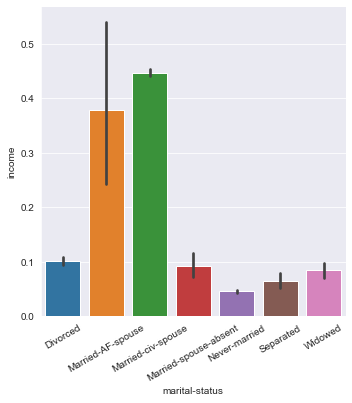

In [18]:
attr = 'marital-status'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

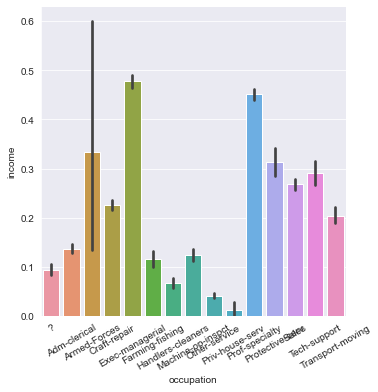

In [21]:
attr = 'occupation'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

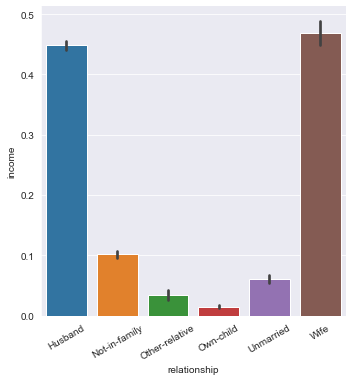

In [22]:
attr = 'relationship'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

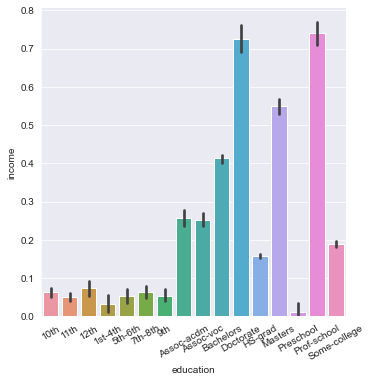

In [23]:
attr = 'education'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

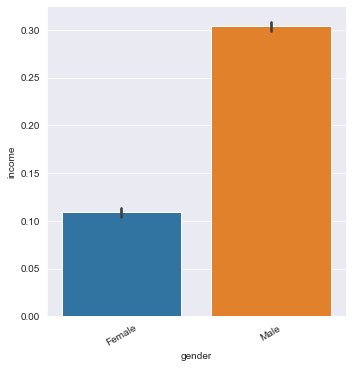

In [24]:
attr = 'gender'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

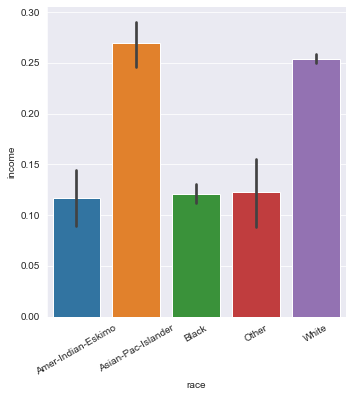

In [25]:
attr = 'race'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

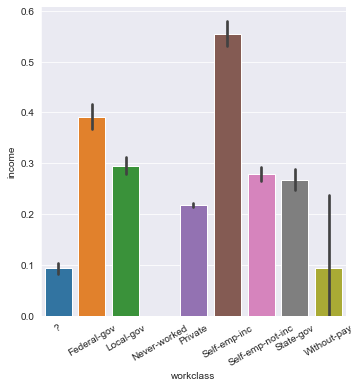

In [ ]:
attr = 'workclass'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

## Train Interpretable Model

Let's train a logistic-regresion model and interpret it's weights

In [51]:
attributes = [
    'marital-status',
    'age',
    'hours-per-week',
    'capital-gain',
    'occupation',
    'relationship',
    'education',
    'gender',
    'race',
    'income'
]

dummy = encode_dummies(df[attributes])

X = dummy.drop('income.>50K', axis=1)
y = dummy['income.>50K']

clf = LogisticRegression(random_state=0).fit(X, y);

odds = pd.DataFrame(
    {
        'Attribute': X.columns,
        'Odds': np.exp(clf.coef_)[0]
    }
);

C:\tools\Anaconda3\envs\forseti\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Top 5 weights

In [52]:
odds.sort_values(by='Odds', ascending=False)

,Attribute,Odds
4,marital-status.Married-civ-spouse,2.789768
12,occupation.Exec-managerial,2.275613
18,occupation.Prof-specialty,2.053952
36,education.Bachelors,1.822046
39,education.Masters,1.713818
41,education.Prof-school,1.299779
37,education.Doctorate,1.241648
27,relationship.Wife,1.204451
20,occupation.Sales,1.072466
21,occupation.Tech-support,1.063840


## Bottomn 5 weights

In [53]:
odds.sort_values(by='Odds', ascending=False)

,Attribute,Odds
4,marital-status.Married-civ-spouse,2.789768
12,occupation.Exec-managerial,2.275613
18,occupation.Prof-specialty,2.053952
36,education.Bachelors,1.822046
39,education.Masters,1.713818
41,education.Prof-school,1.299779
37,education.Doctorate,1.241648
27,relationship.Wife,1.204451
20,occupation.Sales,1.072466
21,occupation.Tech-support,1.063840
